# Air Pollution Forecasting Using LSTM

## Import Data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data_imputed.csv")

In [3]:
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'])

In [6]:
df = df[['timestamp_local','temp','aqi','co','no2','o3','pm10','pm25','so2']]

In [7]:
df.head()

,timestamp_local,temp,aqi,co,no2,o3,pm10,pm25,so2
0,2022-02-01 00:00:00,12.6,385.0,1339.8,76.0,10.7,491.7,347.67,238.0
1,2022-02-01 01:00:00,11.5,404.0,1437.6,76.0,9.3,508.3,359.33,268.0
2,2022-02-01 02:00:00,11.9,421.0,1535.5,76.0,8.0,525.0,371.00,298.0
3,2022-02-01 03:00:00,12.2,425.0,1659.0,68.3,5.3,529.3,374.00,275.7
4,2022-02-01 04:00:00,11.9,430.0,1782.5,60.7,2.7,533.7,377.00,253.3


In [8]:
data = df[['temp','aqi','co','no2','o3','pm10','pm25','so2']]

## Data PreProcessing

In [4]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [10]:
dataset = data
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [13]:
# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(18217, 16)


In [14]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.221709,0.753747,0.237297,0.589147,0.034185,0.704158,0.579534,0.610256,0.196305,0.794433,0.255244,0.589147,0.029712,0.728373,0.599311,0.687180
2,0.196305,0.794433,0.255244,0.589147,0.029712,0.728373,0.599311,0.687180,0.205543,0.830835,0.273209,0.589147,0.025559,0.752735,0.619106,0.764103
3,0.205543,0.830835,0.273209,0.589147,0.025559,0.752735,0.619106,0.764103,0.212471,0.839400,0.295873,0.529457,0.016933,0.759008,0.624194,0.706923
4,0.212471,0.839400,0.295873,0.529457,0.016933,0.759008,0.624194,0.706923,0.205543,0.850107,0.318536,0.470543,0.008626,0.765427,0.629283,0.649487
5,0.205543,0.850107,0.318536,0.470543,0.008626,0.765427,0.629283,0.649487,0.196305,0.858672,0.341200,0.410853,0.000000,0.771699,0.634371,0.592308


In [15]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)',
       'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'],
      dtype='object')

In [18]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = int(365 * 24 * 1.5)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 15) (13140,) (5077, 1, 15) (5077,)


In [19]:
train.shape, test.shape, values.shape

((13140, 16), (5077, 16), (18217, 16))

## Model Fitting

In [20]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
146/146 - 3s - 18ms/step - loss: 0.0185 - val_loss: 5.1229e-04
Epoch 2/50
146/146 - 0s - 3ms/step - loss: 0.0094 - val_loss: 4.7258e-04
Epoch 3/50
146/146 - 0s - 3ms/step - loss: 0.0071 - val_loss: 3.7981e-04
Epoch 4/50
146/146 - 0s - 3ms/step - loss: 0.0055 - val_loss: 3.1794e-04
Epoch 5/50
146/146 - 1s - 5ms/step - loss: 0.0042 - val_loss: 3.5455e-04
Epoch 6/50
146/146 - 0s - 3ms/step - loss: 0.0031 - val_loss: 4.7742e-04
Epoch 7/50
146/146 - 0s - 3ms/step - loss: 0.0021 - val_loss: 5.1269e-04
Epoch 8/50
146/146 - 0s - 3ms/step - loss: 0.0015 - val_loss: 3.6724e-04
Epoch 9/50
146/146 - 1s - 5ms/step - loss: 0.0012 - val_loss: 2.7257e-04
Epoch 10/50
146/146 - 1s - 5ms/step - loss: 0.0011 - val_loss: 2.5603e-04
Epoch 11/50
146/146 - 1s - 5ms/step - loss: 0.0011 - val_loss: 2.5642e-04
Epoch 12/50
146/146 - 1s - 4ms/step - loss: 0.0010 - val_loss: 2.5854e-04
Epoch 13/50
146/146 - 0s - 3ms/step - loss: 9.3841e-04 - val_loss: 2.6153e-04
Epoch 14/50
146/146 - 1s - 5ms/step - loss

In [23]:
import matplotlib.pyplot as plt

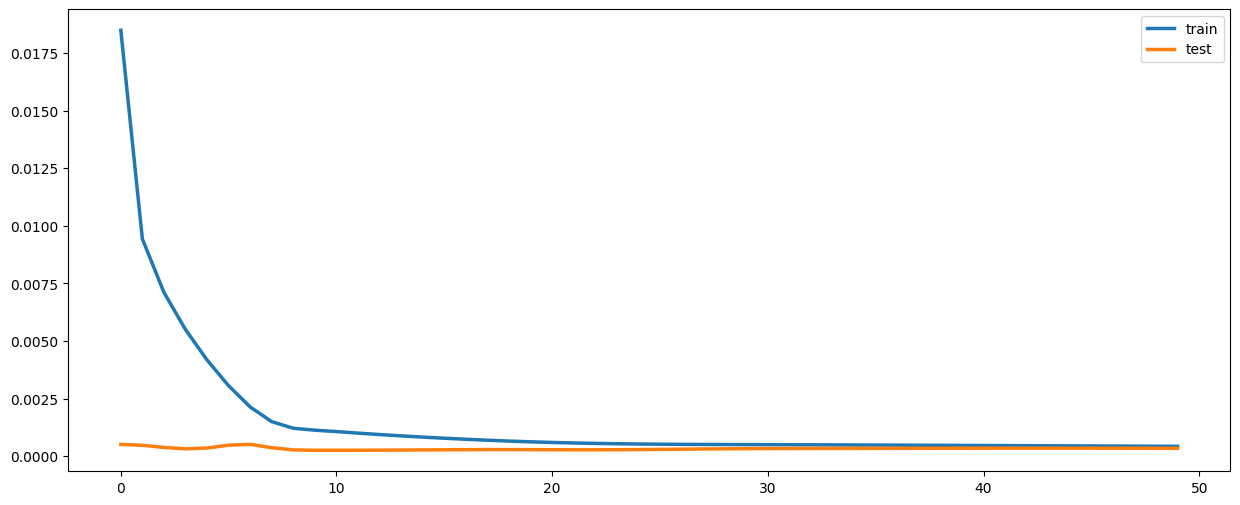

In [24]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [25]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(5077, 1)
(5077,)


In [26]:
test.shape

(5077, 16)

In [27]:
y_test_true = test[:,8]

In [29]:
import numpy as np

In [38]:
poll = np.array(df["temp"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

In [40]:
test_y

array([0.10512821, 0.09923077, 0.09307692, ..., 0.09410257, 0.09307692,
       0.09230769], dtype=float32)

In [41]:
testPredict

array([13544.143, 13535.723, 13512.132, ..., 13345.318, 13349.337,
       13343.454], dtype=float32)

In [36]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict))
print("Test RMSE ="  ,rmse)

Test RMSE = 1496.0729


In [42]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.summary()

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         278,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 295,297 (1.13 MB)

 Trainable params: 295,169 (1.13 MB)

 Non-trainable params: 128 (512.00 B)

In [43]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0533 - val_loss: 0.0035
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 5.5952e-04
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 5.1633e-04
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 1.3735e-04
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 4.4792e-04
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 1.3170e-04
Epoch 12/50
103/103 ━━━

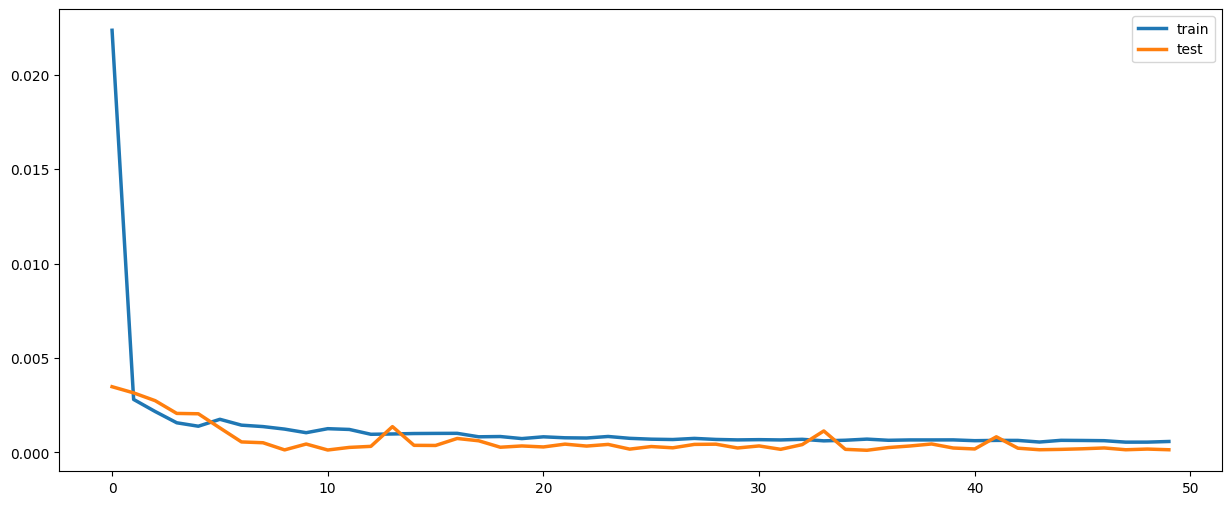

In [44]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [45]:
y_test_true = test[:,8]

In [47]:
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["temp"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24.083620595015915 8.92273586422645


In [49]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 3.4962068


In [51]:
model3 = Sequential()
model3.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model3.add(Dense(32))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())
model3.add(Dense(1))

model3.summary()

C:\Users\Hassan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         278,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 286,913 (1.09 MB)

 Trainable params: 286,849 (1.09 MB)

 Non-trainable params: 64 (256.00 B)

In [52]:
model3.compile(loss='mse', optimizer='adam')

hist3 = model3.fit(train_X, train_y, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0770 - val_loss: 0.0106
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058 - val_loss: 0.0098
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0090
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 0.0066
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0070
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0073
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0059
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

In [59]:
y_test_true = test[:,8]

In [64]:
y_train_true

array([254.60426, 255.33974, 255.89134, ..., 267.4751 , 265.45255,
       265.45255], dtype=float32)

In [65]:
testPredict3 = model3.predict(test_X)
testPredict3 = testPredict3.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["temp"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict3 = testPredict3*stdop + meanop

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24.083620595015915 8.92273586422645


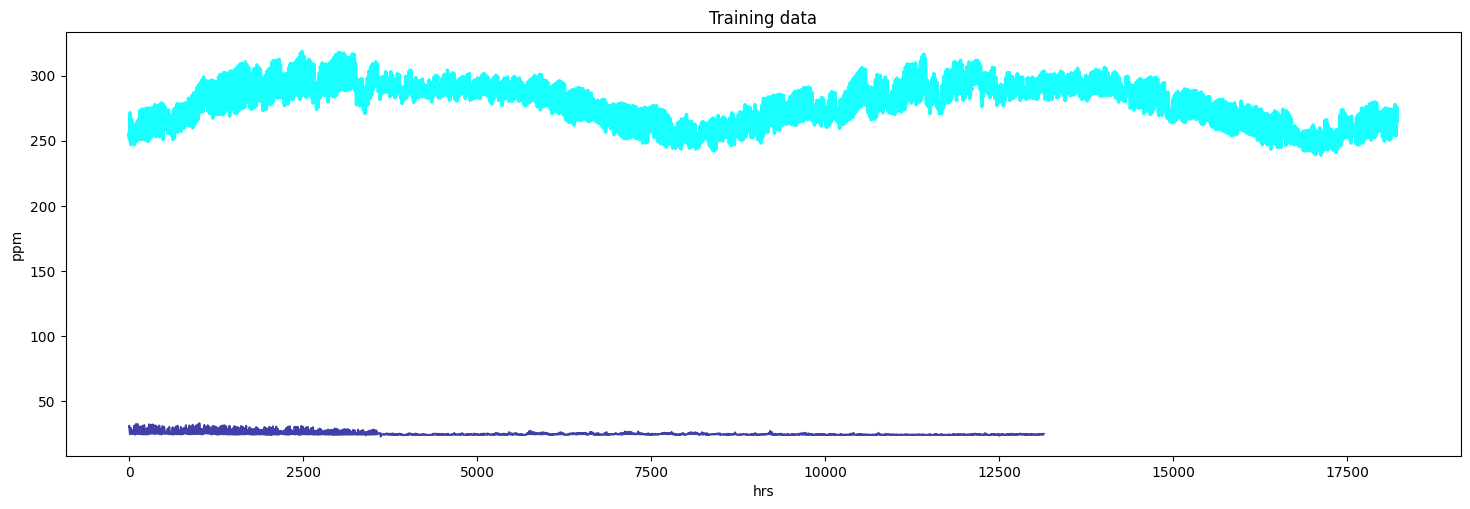

In [66]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_train_true, c = "cyan", alpha = 0.90, linewidth = 2.5)
plt.plot(trainPredict3, c = "darkblue", alpha = 0.75)
plt.title("Training data")
plt.show()

In [68]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict3))
print("Training RMSE ="  ,rmse)

Training RMSE = 3.4523358
